In [1]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torchvision.models as models
from libauc.optimizers import SGD, Adam,PESG
from libauc.losses import CrossEntropyLoss, AUCMLoss
from torch.utils.data import DataLoader, random_split
import os
os.environ['medmnist_data_dir'] = 'D:\\Download\\CSCE633\\project\\data'
import medmnist
from medmnist.dataset import PneumoniaMNIST
# BreastMNIST, PneumoniaMNIST, ChestMNIST, NoduleMNIST3D, AdrenalMNIST3D, VesselMNIST3D, SynapseMNIST3D
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from medmnist import INFO, Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

d:\adahx\anaconda3\envs\new_env_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parameters

In [22]:
data_flag = 'pneumoniamnist'

NUM_EPOCHS = 50
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

preprosessing

In [3]:
# data augmentation
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [4]:
data_dir = 'D:\\Download\\CSCE633\\project\\data'

In [5]:
# load data
train_data = DataClass(root=data_dir, split = 'train', transform=data_transform)
test_data = DataClass(root=data_dir, split = 'test', transform=data_transform)
val_data = DataClass(root=data_dir, split = 'val', transform=data_transform)


In [6]:
# dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=2*BATCH_SIZE, shuffle=False)

In [7]:
print(train_data)
print('=====================')
print(test_data)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: D:\Download\CSCE633\project\data
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: D:\Download\CSCE633\project\data
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal

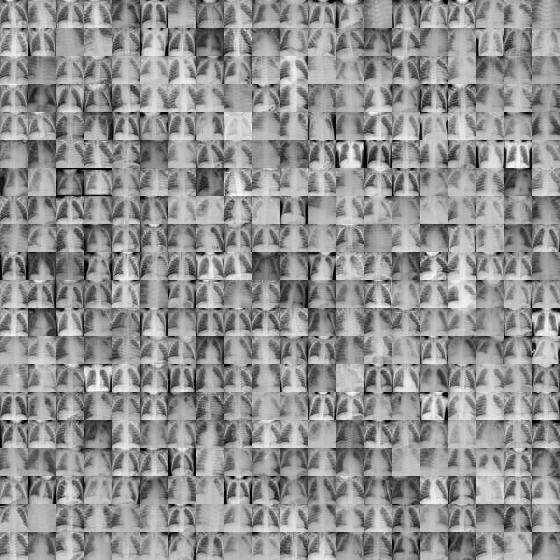

In [8]:
train_data.montage()

evaluation function

In [9]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    total = 0
    auc_score = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Calculate AUC score (assuming binary classification)
            targets = targets.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()[:, 1]  # Get scores for the positive class
            auc_score += roc_auc_score(targets, outputs)

    acc = correct / total
    auc_score /= len(dataloader)

    return auc_score, acc


# DAM

In [10]:
# Define the model
model = models.resnet18(pretrained=False, num_classes=n_classes)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [11]:
criterion = nn.CrossEntropyLoss()

## Resnet18

In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Training with Adam optimizer...


100%|██████████| 74/74 [00:06<00:00, 12.20it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.9644718375780322, Train ACC: 38.3500424808836
Test AUC: 0.8852634818166767, Test ACC: 68.98397435897436
***************************
==> Best test AUC and ACC score updated: 0.8853, 68.9840
***************************


100%|██████████| 74/74 [00:02<00:00, 25.95it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.9823355279837397, Train ACC: 39.8160577740017
Test AUC: 0.9312625773881889, Test ACC: 70.36217948717949
***************************
==> Best test AUC and ACC score updated: 0.9313, 70.3622
***************************


100%|██████████| 74/74 [00:02<00:00, 26.28it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.9871598079127016, Train ACC: 38.40654205607477
Test AUC: 0.93958013329976, Test ACC: 68.25961538461539
***************************
==> Best test AUC and ACC score updated: 0.9396, 68.2596
***************************


100%|██████████| 74/74 [00:02<00:00, 26.32it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.9876083911328482, Train ACC: 37.795666949872555
Test AUC: 0.9366629109720291, Test ACC: 67.17628205128206


100%|██████████| 74/74 [00:02<00:00, 26.14it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.9799110136212004, Train ACC: 34.170773152081566
Test AUC: 0.8888224824339199, Test ACC: 63.94551282051282


100%|██████████| 74/74 [00:02<00:00, 26.20it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.9791532551339146, Train ACC: 34.78589634664401
Test AUC: 0.9356702498436696, Test ACC: 64.18910256410257


100%|██████████| 74/74 [00:02<00:00, 26.04it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.9898375793265123, Train ACC: 40.08411214953271
Test AUC: 0.9347359328928647, Test ACC: 71.60576923076923


100%|██████████| 74/74 [00:02<00:00, 25.98it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.9870760236125122, Train ACC: 40.75658453695837
Test AUC: 0.9437064942129456, Test ACC: 72.07051282051282
***************************
==> Best test AUC and ACC score updated: 0.9437, 72.0705
***************************


100%|██████████| 74/74 [00:02<00:00, 25.76it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.9888514150693932, Train ACC: 39.57179269328802
Test AUC: 0.9493007917689598, Test ACC: 69.8301282051282
***************************
==> Best test AUC and ACC score updated: 0.9493, 69.8301
***************************


100%|██████████| 74/74 [00:02<00:00, 25.67it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.9909448816413513, Train ACC: 38.497451146983856
Test AUC: 0.9548414532622724, Test ACC: 68.26602564102564
***************************
==> Best test AUC and ACC score updated: 0.9548, 68.2660
***************************


100%|██████████| 74/74 [00:02<00:00, 26.00it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.9902662396001812, Train ACC: 38.924808836023786
Test AUC: 0.9446526540491267, Test ACC: 68.67948717948718


100%|██████████| 74/74 [00:02<00:00, 25.99it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.9916168618143375, Train ACC: 39.55267629566695
Test AUC: 0.957322410391396, Test ACC: 70.0224358974359
***************************
==> Best test AUC and ACC score updated: 0.9573, 70.0224
***************************


100%|██████████| 74/74 [00:02<00:00, 25.54it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.9888367260124006, Train ACC: 40.67799490229397
Test AUC: 0.9396614835732121, Test ACC: 72.89423076923077


100%|██████████| 74/74 [00:02<00:00, 26.03it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.9899981210028107, Train ACC: 40.11469838572642
Test AUC: 0.9429291095989871, Test ACC: 70.98397435897436


100%|██████████| 74/74 [00:02<00:00, 26.21it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.9919743067103344, Train ACC: 39.21028037383178
Test AUC: 0.9550155127501565, Test ACC: 68.40384615384616


100%|██████████| 74/74 [00:02<00:00, 25.99it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.9903241410890149, Train ACC: 38.30076465590484
Test AUC: 0.9447797305510546, Test ACC: 68.01923076923077


100%|██████████| 74/74 [00:02<00:00, 25.73it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.9908801998883939, Train ACC: 40.62744265080714
Test AUC: 0.9437374857291037, Test ACC: 72.06089743589743


100%|██████████| 74/74 [00:02<00:00, 26.26it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.9919745560053591, Train ACC: 39.603653355989806
Test AUC: 0.9486251981602299, Test ACC: 70.29166666666667


100%|██████████| 74/74 [00:02<00:00, 26.28it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.9858442621863891, Train ACC: 42.34961767204758
Test AUC: 0.9115273136435237, Test ACC: 74.52884615384616


100%|██████████| 74/74 [00:02<00:00, 25.65it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9897334867224754, Train ACC: 40.454970263381476
Test AUC: 0.9349821516433023, Test ACC: 72.47435897435898


100%|██████████| 74/74 [00:02<00:00, 26.26it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9911450835462442, Train ACC: 39.841546304163124
Test AUC: 0.9474547847073549, Test ACC: 71.11858974358974


100%|██████████| 74/74 [00:02<00:00, 26.20it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.99309479600333, Train ACC: 39.05692438402719
Test AUC: 0.9558211862636773, Test ACC: 68.91025641025641


100%|██████████| 74/74 [00:02<00:00, 24.73it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9897452230846632, Train ACC: 41.023789294817334
Test AUC: 0.9508832151549141, Test ACC: 72.47115384615384


100%|██████████| 74/74 [00:02<00:00, 26.24it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9930452869603412, Train ACC: 39.090484282073064
Test AUC: 0.9533256813563679, Test ACC: 69.18589743589743


100%|██████████| 74/74 [00:02<00:00, 26.28it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.9946682891754701, Train ACC: 39.88020390824129
Test AUC: 0.950601408504984, Test ACC: 71.21474358974359


100%|██████████| 74/74 [00:02<00:00, 25.54it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.9925329236888545, Train ACC: 39.05480033984707
Test AUC: 0.9576337325380513, Test ACC: 68.61538461538461
***************************
==> Best test AUC and ACC score updated: 0.9576, 68.6154
***************************


100%|██████████| 74/74 [00:02<00:00, 25.99it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9945837701622587, Train ACC: 40.389549702633815
Test AUC: 0.9471055087414667, Test ACC: 71.55448717948718


100%|██████████| 74/74 [00:02<00:00, 26.22it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.9950292470364546, Train ACC: 39.72217502124044
Test AUC: 0.9582733695461055, Test ACC: 69.3974358974359
***************************
==> Best test AUC and ACC score updated: 0.9583, 69.3974
***************************


100%|██████████| 74/74 [00:02<00:00, 25.54it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.9943614951498745, Train ACC: 39.8428207306712
Test AUC: 0.9594086251341377, Test ACC: 70.36217948717949
***************************
==> Best test AUC and ACC score updated: 0.9594, 70.3622
***************************


100%|██████████| 74/74 [00:02<00:00, 26.21it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9949575396943171, Train ACC: 39.55692438402719
Test AUC: 0.9643694210333653, Test ACC: 69.85576923076923
***************************
==> Best test AUC and ACC score updated: 0.9644, 69.8558
***************************


100%|██████████| 74/74 [00:02<00:00, 26.12it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.9942498355840065, Train ACC: 39.783347493627865
Test AUC: 0.9584414764182803, Test ACC: 70.40064102564102


100%|██████████| 74/74 [00:02<00:00, 25.35it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9955264066683508, Train ACC: 39.76338147833475
Test AUC: 0.9562772464558353, Test ACC: 69.91346153846153


100%|██████████| 74/74 [00:02<00:00, 25.77it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9929495036887878, Train ACC: 39.08198810535259
Test AUC: 0.9471335680951057, Test ACC: 68.89102564102564


100%|██████████| 74/74 [00:02<00:00, 26.09it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9949945060639507, Train ACC: 39.281648258283774
Test AUC: 0.9487812463466815, Test ACC: 70.08653846153847


100%|██████████| 74/74 [00:02<00:00, 25.67it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9949549166089071, Train ACC: 39.84409515717927
Test AUC: 0.953750470600305, Test ACC: 71.96153846153847


100%|██████████| 74/74 [00:02<00:00, 26.23it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.9947452334774769, Train ACC: 39.476210705182666
Test AUC: 0.9499981084150614, Test ACC: 70.41025641025641


100%|██████████| 74/74 [00:02<00:00, 26.23it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.9942966488007401, Train ACC: 39.732370433305015
Test AUC: 0.9591772457771427, Test ACC: 70.04166666666667


100%|██████████| 74/74 [00:02<00:00, 25.28it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9937541127205681, Train ACC: 39.81478334749363
Test AUC: 0.9604079289523261, Test ACC: 71.0576923076923


100%|██████████| 74/74 [00:02<00:00, 25.93it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9944145830969422, Train ACC: 39.95369583687341
Test AUC: 0.9422109918522772, Test ACC: 70.83974358974359


100%|██████████| 74/74 [00:02<00:00, 26.17it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9929805148593537, Train ACC: 39.925233644859816
Test AUC: 0.9411630742519819, Test ACC: 70.84294871794872


100%|██████████| 74/74 [00:02<00:00, 25.39it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.994784477187356, Train ACC: 39.45242141036533
Test AUC: 0.9509042360390204, Test ACC: 69.87179487179488


100%|██████████| 74/74 [00:02<00:00, 25.58it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9939474712663909, Train ACC: 40.56202209005947
Test AUC: 0.9686144095870697, Test ACC: 72.41666666666667
***************************
==> Best test AUC and ACC score updated: 0.9686, 72.4167
***************************


100%|██████████| 74/74 [00:02<00:00, 26.05it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.99513463634552, Train ACC: 39.74851316907392
Test AUC: 0.9524691336510474, Test ACC: 70.30128205128206


100%|██████████| 74/74 [00:02<00:00, 25.60it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9947785413904561, Train ACC: 39.51444350042481
Test AUC: 0.9474978134325625, Test ACC: 69.98397435897436


100%|██████████| 74/74 [00:02<00:00, 26.11it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9953895612712648, Train ACC: 39.50382327952421
Test AUC: 0.9608095325213919, Test ACC: 69.88782051282051


100%|██████████| 74/74 [00:02<00:00, 26.13it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.995023115569699, Train ACC: 40.658453695836876
Test AUC: 0.950106465871435, Test ACC: 72.6474358974359


100%|██████████| 74/74 [00:02<00:00, 25.41it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9946092649850398, Train ACC: 39.58453695836874
Test AUC: 0.9535363605030159, Test ACC: 70.52564102564102


100%|██████████| 74/74 [00:02<00:00, 26.17it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9865944109169217, Train ACC: 42.601529311809685
Test AUC: 0.9497860544699088, Test ACC: 73.73717948717949


100%|██████████| 74/74 [00:02<00:00, 26.18it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9956788070711337, Train ACC: 40.31096006796941
Test AUC: 0.9534541836352233, Test ACC: 71.87820512820512


100%|██████████| 74/74 [00:02<00:00, 25.51it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9953611535002791, Train ACC: 39.60025488530162
Test AUC: 0.9533868399713267, Test ACC: 71.01282051282051
Training with SGD optimizer...


100%|██████████| 74/74 [00:02<00:00, 28.39it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.9958637971106977, Train ACC: 39.912914188615126
Test AUC: 0.957153571792082, Test ACC: 70.89102564102564
***************************
==> Best test AUC and ACC score updated: 0.9572, 70.8910
***************************


100%|██████████| 74/74 [00:02<00:00, 28.11it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.9969489802989918, Train ACC: 39.81860662701784
Test AUC: 0.9557570769971641, Test ACC: 70.68589743589743


100%|██████████| 74/74 [00:02<00:00, 27.89it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.996725853738241, Train ACC: 39.908666100254884
Test AUC: 0.9564321612960878, Test ACC: 70.98397435897436


100%|██████████| 74/74 [00:02<00:00, 28.07it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.9967695280783617, Train ACC: 39.716652506372135
Test AUC: 0.9647785670273207, Test ACC: 70.8974358974359
***************************
==> Best test AUC and ACC score updated: 0.9648, 70.8974
***************************


100%|██████████| 74/74 [00:02<00:00, 28.53it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.9972791733117914, Train ACC: 39.75998300764656
Test AUC: 0.9706315847296251, Test ACC: 71.04166666666667
***************************
==> Best test AUC and ACC score updated: 0.9706, 71.0417
***************************


100%|██████████| 74/74 [00:02<00:00, 28.04it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.9964328574563687, Train ACC: 39.850467289719624
Test AUC: 0.958505327725638, Test ACC: 70.5448717948718


100%|██████████| 74/74 [00:02<00:00, 28.39it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.9971437569028523, Train ACC: 39.79396771452846
Test AUC: 0.9614108149433147, Test ACC: 70.40064102564102


100%|██████████| 74/74 [00:02<00:00, 28.35it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.996956895100937, Train ACC: 39.908666100254884
Test AUC: 0.9625939256143525, Test ACC: 71.10897435897436


100%|██████████| 74/74 [00:02<00:00, 28.34it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.997530529150197, Train ACC: 39.78971962616822
Test AUC: 0.9633640328153279, Test ACC: 70.80128205128206


100%|██████████| 74/74 [00:02<00:00, 28.10it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.9968943892806363, Train ACC: 39.67162276975361
Test AUC: 0.9654576121219136, Test ACC: 70.00320512820512


100%|██████████| 74/74 [00:02<00:00, 27.54it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.9973170394266354, Train ACC: 39.650807136788444
Test AUC: 0.9658962160602031, Test ACC: 70.88141025641026


100%|██████████| 74/74 [00:02<00:00, 28.37it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.9969059361406412, Train ACC: 39.78971962616822
Test AUC: 0.9602522819918796, Test ACC: 71.19871794871794


100%|██████████| 74/74 [00:02<00:00, 27.95it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.9966912736506309, Train ACC: 39.8589634664401
Test AUC: 0.9581066728906349, Test ACC: 70.5576923076923


100%|██████████| 74/74 [00:02<00:00, 28.36it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.9970867150122249, Train ACC: 39.75276125743415
Test AUC: 0.965253810374537, Test ACC: 70.3525641025641


100%|██████████| 74/74 [00:02<00:00, 28.41it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.9976091106209685, Train ACC: 39.79481733220051
Test AUC: 0.9677770794717422, Test ACC: 71.02564102564102


100%|██████████| 74/74 [00:02<00:00, 27.47it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.9970944540811968, Train ACC: 39.69838572642311
Test AUC: 0.9646827686758387, Test ACC: 70.39423076923077


100%|██████████| 74/74 [00:02<00:00, 28.40it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.9973358040757571, Train ACC: 39.76295666949873
Test AUC: 0.966009659667753, Test ACC: 70.5


100%|██████████| 74/74 [00:02<00:00, 28.26it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.9974171089344994, Train ACC: 39.783772302463895
Test AUC: 0.9696547526882278, Test ACC: 70.78205128205128


100%|██████████| 74/74 [00:02<00:00, 27.28it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.9974174738886267, Train ACC: 39.979609175870856
Test AUC: 0.9546678295504186, Test ACC: 70.81089743589743


100%|██████████| 74/74 [00:02<00:00, 28.38it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9973106911963854, Train ACC: 39.843670348343245
Test AUC: 0.965821349383738, Test ACC: 70.67948717948718


100%|██████████| 74/74 [00:02<00:00, 28.20it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9975011794450128, Train ACC: 39.73874256584537
Test AUC: 0.9652665321782766, Test ACC: 70.74679487179488


100%|██████████| 74/74 [00:02<00:00, 27.43it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.9978708118427438, Train ACC: 39.85131690739168
Test AUC: 0.9624647216464106, Test ACC: 70.375


100%|██████████| 74/74 [00:02<00:00, 28.41it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9971160290104435, Train ACC: 39.71367884451997
Test AUC: 0.9625097691305952, Test ACC: 70.91346153846153


100%|██████████| 74/74 [00:02<00:00, 28.17it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9976147937785559, Train ACC: 39.7892948173322
Test AUC: 0.9638862170988132, Test ACC: 70.88782051282051


100%|██████████| 74/74 [00:02<00:00, 28.06it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.9977414278494773, Train ACC: 39.692013593882756
Test AUC: 0.9649449248309867, Test ACC: 70.28205128205128


100%|██████████| 74/74 [00:02<00:00, 28.39it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.9977275692946821, Train ACC: 39.62361937128292
Test AUC: 0.9623194391104615, Test ACC: 70.65705128205128


100%|██████████| 74/74 [00:02<00:00, 28.24it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9971047784733694, Train ACC: 39.79184367034834
Test AUC: 0.9651869039230212, Test ACC: 70.5224358974359


100%|██████████| 74/74 [00:02<00:00, 28.32it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.997357600105604, Train ACC: 39.725148683092605
Test AUC: 0.972247217032869, Test ACC: 70.64423076923077
***************************
==> Best test AUC and ACC score updated: 0.9722, 70.6442
***************************


100%|██████████| 74/74 [00:02<00:00, 28.24it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.997161593307935, Train ACC: 39.84961767204758
Test AUC: 0.9612629585505301, Test ACC: 71.09615384615384


100%|██████████| 74/74 [00:02<00:00, 28.41it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9976988548206372, Train ACC: 39.83432455395072
Test AUC: 0.9640138651402952, Test ACC: 70.30448717948718


100%|██████████| 74/74 [00:02<00:00, 27.65it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.9978728966373067, Train ACC: 39.87892948173322
Test AUC: 0.9689482297184536, Test ACC: 70.1826923076923


100%|██████████| 74/74 [00:02<00:00, 27.69it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9970777470760313, Train ACC: 39.97875955819881
Test AUC: 0.9675454934131837, Test ACC: 71.23397435897436


100%|██████████| 74/74 [00:02<00:00, 27.82it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9973619305794649, Train ACC: 39.80033984706882
Test AUC: 0.9701329580534646, Test ACC: 70.26923076923077


100%|██████████| 74/74 [00:02<00:00, 28.09it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9967027612517253, Train ACC: 39.8768054375531
Test AUC: 0.9672030725616466, Test ACC: 71.17948717948718


100%|██████████| 74/74 [00:02<00:00, 27.59it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9984237705060967, Train ACC: 39.84409515717927
Test AUC: 0.9706908166697042, Test ACC: 70.51923076923077


100%|██████████| 74/74 [00:02<00:00, 28.02it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.9972198494042601, Train ACC: 39.91801189464741
Test AUC: 0.9578144187245409, Test ACC: 71.1474358974359


100%|██████████| 74/74 [00:02<00:00, 28.36it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.997840773384666, Train ACC: 40.05649957519116
Test AUC: 0.9698514753942415, Test ACC: 71.21794871794872


100%|██████████| 74/74 [00:02<00:00, 27.31it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9974654685818338, Train ACC: 39.94180118946474
Test AUC: 0.9672920525712125, Test ACC: 70.9326923076923


100%|██████████| 74/74 [00:02<00:00, 28.34it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9971222184453239, Train ACC: 39.88317757009346
Test AUC: 0.9663623172615015, Test ACC: 70.73397435897436


100%|██████████| 74/74 [00:02<00:00, 28.25it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9971090554124058, Train ACC: 39.90994052676296
Test AUC: 0.9601332486316515, Test ACC: 70.67948717948718


100%|██████████| 74/74 [00:02<00:00, 27.79it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9972381061449906, Train ACC: 39.91886151231946
Test AUC: 0.9658012028299796, Test ACC: 70.83653846153847


100%|██████████| 74/74 [00:02<00:00, 28.27it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9978651091800069, Train ACC: 39.94519966015293
Test AUC: 0.9659407429720603, Test ACC: 71.03846153846153


100%|██████████| 74/74 [00:02<00:00, 28.58it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9979181449147813, Train ACC: 39.847068819031435
Test AUC: 0.9652940422819964, Test ACC: 70.4775641025641


100%|██████████| 74/74 [00:02<00:00, 28.12it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9967552846461832, Train ACC: 39.751911639762106
Test AUC: 0.9651729112904264, Test ACC: 70.00641025641026


100%|██████████| 74/74 [00:02<00:00, 28.21it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9971863631242499, Train ACC: 39.81648258283772
Test AUC: 0.971382913736044, Test ACC: 70.66346153846153


100%|██████████| 74/74 [00:02<00:00, 28.27it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.9977221767858443, Train ACC: 39.871707731520814
Test AUC: 0.9612677025794307, Test ACC: 70.3974358974359


100%|██████████| 74/74 [00:02<00:00, 28.37it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9977531564317201, Train ACC: 39.82667799490229
Test AUC: 0.9676042700522803, Test ACC: 70.91666666666667


100%|██████████| 74/74 [00:02<00:00, 28.13it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9971092639616009, Train ACC: 39.84069668649108
Test AUC: 0.9699858629727354, Test ACC: 70.46153846153847


100%|██████████| 74/74 [00:02<00:00, 28.48it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9973900983162083, Train ACC: 39.90144435004248
Test AUC: 0.9650542298210217, Test ACC: 70.96794871794872


100%|██████████| 74/74 [00:02<00:00, 28.37it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9977310884661268, Train ACC: 39.68479184367035
Test AUC: 0.9694905535077629, Test ACC: 70.3173076923077
Best model: SGD, AUC: 0.9722, ACC: 70.6442, epoch: 28


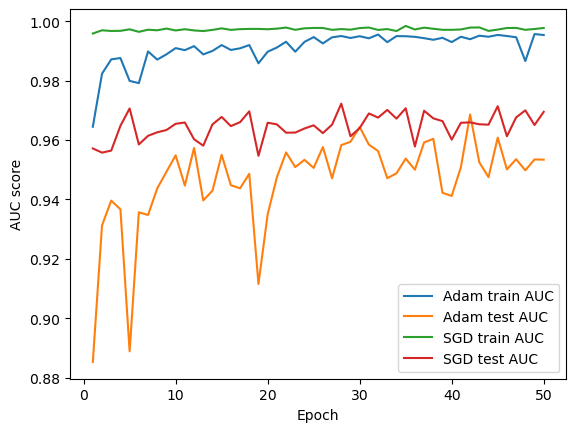

In [13]:
import copy
optimizers = {
    'Adam': Adam(model.parameters(), lr=lr, weight_decay=1e-4),
    'SGD': SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
}

best_models = {}
best_aucs = {}

for optimizer_name, optimizer in optimizers.items():
    print("========================================")
    print(f"Training with {optimizer_name} optimizer...")
    print("========================================")

    model.train()  # Reset the model to training mode

    best_auc = 0
    best_acc = 0
    best_epoch = 0

    train_auc_scores = []
    test_auc_scores = []
    epochs = []

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        train_loss = 0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        print(f"==> Evaluating after epoch {epoch + 1} ...")
        train_metrics = evaluate(train_loader)
        test_metrics = evaluate(test_loader)
        
        print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
        print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

        # Check if AUC score improved
        if test_metrics[0] > best_auc:
            best_auc = test_metrics[0]
            best_acc = test_metrics[1]
            best_epoch = epoch + 1
            print("***************************")
            print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
            print("***************************")
            best_models[optimizer_name] = {
                'state_dict': copy.deepcopy(model.state_dict()),
                'auc': best_auc,
                'acc': best_acc,
                'epoch': best_epoch
            }

        # Append AUC scores and epoch numbers
        train_auc_scores.append(train_metrics[0])
        test_auc_scores.append(test_metrics[0])
        epochs.append(epoch+1)

    best_aucs[optimizer_name] = best_auc

    # Plot the train and test AUC scores vs epoch for each optimizer
    plt.plot(epochs, train_auc_scores, label=f"{optimizer_name} train AUC")
    plt.plot(epochs, test_auc_scores, label=f"{optimizer_name} test AUC")

# Find the optimizer with the best AUC score
best_optimizer = max(best_aucs, key=best_aucs.get)
best_model_info = best_models[best_optimizer]

# Save the best model
torch.save(best_model_info['state_dict'], 'best_pretrained_model_pneumoniamnist.pth')

print(f"Best model: {best_optimizer}, AUC: {best_model_info['auc']:.4f}, ACC: {best_model_info['acc']:.4f}, epoch: {best_model_info['epoch']}")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

# LibAUC

In [14]:
# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List the files in the current directory
files = os.listdir(current_directory)
print("Files in the current directory:")
for file in files:
    print(file)

Current working directory: d:\Download\CSCE633\project
Files in the current directory:
AdrenalMNIST3D.ipynb
best_model_adrenalmnist3d.pth
best_model_breastmnist.pth
best_model_breastmnist_no_dropout.pth
best_model_chestmnist.pth
best_model_nodulemnist3d.pth
best_model_pneumoniamnist.pth
best_model_pneumoniamnist_no_dropout.pth
best_model_synapsemnist3d.pth
best_pretraind_model_breastmnist.pth
best_pretraind_model_pneumoniamnist.pth
best_pretrained_model_adrenalmnist3d.pth
best_pretrained_model_chestmnist.pth
best_pretrained_model_nodulemnist3d.pth
best_pretrained_model_pneumoniamnist.pth
best_pretrained_model_synapsemnist3d.pth
best_pretrained_model_vesselmnist3d.pth
BreastMNIST.ipynb
ChestMNIST.ipynb
CSE633-Spring23-Project-Description.pdf.pdf
data
get_started.ipynb
load_all_data.ipynb
NoduleMNIST3D.ipynb
PneumoniaMNIST.ipynb
resnet2p1d.py
SynapseMNIST3D.ipynb
VesselMNIST3D.ipynb
__pycache__


## ResNet18 with dropout

In [15]:
from torchvision.models.resnet import ResNet, BasicBlock
class ResNet18WithDropout(ResNet):
    def __init__(self, num_classes=2, dropout_rate=0.7):
        super(ResNet18WithDropout, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change the input channels to 1
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)  # Change the output size to match the pretrained model

# Instantiate the modified ResNet18 with dropout
model = ResNet18WithDropout(dropout_rate=0.7)

# Load the state dictionary from the .pth file
pretrained_weights = torch.load("best_pretraind_model_pneumoniamnist.pth")

In [16]:
def fix_state_dict_keys(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

fixed_pretrained_weights = fix_state_dict_keys(pretrained_weights)

In [17]:
# Transfer the weights from the pretrained model to the modified model with dropout
model.load_state_dict(fixed_pretrained_weights, strict=False)

<All keys matched successfully>

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet18WithDropout(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

parameters

In [19]:
SEED = 123
BATCH_SIZE = 64
lr = 0.001 
epoch_decay = 2e-3
weight_decay = 1e-5
margin = 1.0

In [20]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

100%|██████████| 74/74 [00:03<00:00, 22.70it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.9910845835195348, Train ACC: 31.065420560747665
Test AUC: 0.9472381703762354, Test ACC: 61.76282051282051
==> Best test AUC and ACC score updated: 0.9472, 61.7628


100%|██████████| 74/74 [00:03<00:00, 24.58it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.9903347984893087, Train ACC: 31.61299915038233
Test AUC: 0.9412122815879777, Test ACC: 61.48717948717949


100%|██████████| 74/74 [00:03<00:00, 24.48it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.990519946562644, Train ACC: 30.206032285471537
Test AUC: 0.935750879163882, Test ACC: 59.92307692307692


100%|██████████| 74/74 [00:03<00:00, 22.08it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.987824857751745, Train ACC: 32.717926932880204
Test AUC: 0.9454583682484149, Test ACC: 63.08974358974359


100%|██████████| 74/74 [00:03<00:00, 23.80it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.9899961671564109, Train ACC: 31.24001699235344
Test AUC: 0.9347296718049602, Test ACC: 62.35576923076923


100%|██████████| 74/74 [00:03<00:00, 23.72it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.9899629768146719, Train ACC: 31.944350042480885
Test AUC: 0.9475303340194099, Test ACC: 62.11538461538461
==> Best test AUC and ACC score updated: 0.9475, 62.1154


100%|██████████| 74/74 [00:03<00:00, 22.89it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.9914813493734398, Train ACC: 31.135514018691588
Test AUC: 0.9438048252543549, Test ACC: 61.256410256410255


100%|██████████| 74/74 [00:03<00:00, 23.39it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.989770060738072, Train ACC: 30.892948173322004
Test AUC: 0.9323961610351962, Test ACC: 61.5224358974359


100%|██████████| 74/74 [00:03<00:00, 23.67it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.9896425083421478, Train ACC: 31.914613423959217
Test AUC: 0.9396039141201614, Test ACC: 62.07692307692308


100%|██████████| 74/74 [00:03<00:00, 23.41it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.991490013652507, Train ACC: 31.327102803738317
Test AUC: 0.9462383695746318, Test ACC: 60.71474358974359


100%|██████████| 74/74 [00:03<00:00, 23.56it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.988321948386987, Train ACC: 30.818181818181817
Test AUC: 0.942692928925214, Test ACC: 61.30128205128205


100%|██████████| 74/74 [00:03<00:00, 23.43it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.9900342320403287, Train ACC: 31.28377230246389
Test AUC: 0.9334837640934047, Test ACC: 60.99679487179487


100%|██████████| 74/74 [00:03<00:00, 23.42it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.992226463046331, Train ACC: 33.053525913338994
Test AUC: 0.945148907922946, Test ACC: 64.0673076923077


100%|██████████| 74/74 [00:03<00:00, 23.07it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.9926001200042931, Train ACC: 31.66355140186916
Test AUC: 0.9307635870677554, Test ACC: 61.916666666666664


100%|██████████| 74/74 [00:03<00:00, 22.74it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.9906703688570963, Train ACC: 32.1822429906542
Test AUC: 0.9363319571184731, Test ACC: 62.10897435897436


100%|██████████| 74/74 [00:03<00:00, 23.47it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.9909196706322202, Train ACC: 32.144010195412065
Test AUC: 0.9353792064695765, Test ACC: 62.458333333333336


100%|██████████| 74/74 [00:03<00:00, 23.52it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.992415668037006, Train ACC: 30.78249787595582
Test AUC: 0.926854507317526, Test ACC: 59.48397435897436


100%|██████████| 74/74 [00:03<00:00, 21.89it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.9884096076108683, Train ACC: 32.44689889549703
Test AUC: 0.9432202867224438, Test ACC: 62.5224358974359


100%|██████████| 74/74 [00:03<00:00, 23.47it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.990220821691095, Train ACC: 32.00552251486831
Test AUC: 0.9392427968852373, Test ACC: 62.47435897435897


100%|██████████| 74/74 [00:03<00:00, 23.44it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9911481510000252, Train ACC: 31.78462192013594
Test AUC: 0.939331518464243, Test ACC: 61.43910256410256


100%|██████████| 74/74 [00:03<00:00, 21.83it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9914922284099503, Train ACC: 31.939252336448597
Test AUC: 0.9469731716191042, Test ACC: 62.69551282051282


100%|██████████| 74/74 [00:03<00:00, 23.61it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.9903759734369604, Train ACC: 30.549702633814782
Test AUC: 0.9389581531139063, Test ACC: 59.85576923076923


100%|██████████| 74/74 [00:03<00:00, 22.88it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9902254855253579, Train ACC: 31.68819031435854
Test AUC: 0.9403343296125449, Test ACC: 62.80128205128205


100%|██████████| 74/74 [00:03<00:00, 23.47it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9899592743792122, Train ACC: 32.37298215802889
Test AUC: 0.9404428424958773, Test ACC: 61.881410256410255


100%|██████████| 74/74 [00:03<00:00, 23.64it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.9914408847928787, Train ACC: 31.646134239592183
Test AUC: 0.9301062912612856, Test ACC: 62.77884615384615


100%|██████████| 74/74 [00:03<00:00, 22.93it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.990095803176059, Train ACC: 31.7463891248938
Test AUC: 0.9444068110049418, Test ACC: 63.56730769230769


100%|██████████| 74/74 [00:03<00:00, 23.49it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9920861558300792, Train ACC: 30.80926083262532
Test AUC: 0.9429569367202679, Test ACC: 61.32692307692308


100%|██████████| 74/74 [00:03<00:00, 23.56it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.990602506575677, Train ACC: 31.135089209855565
Test AUC: 0.9485851326322594, Test ACC: 62.46153846153846
==> Best test AUC and ACC score updated: 0.9486, 62.4615


100%|██████████| 74/74 [00:03<00:00, 22.53it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.9910766153017065, Train ACC: 32.54757858963467
Test AUC: 0.9454145235081215, Test ACC: 63.09615384615385


100%|██████████| 74/74 [00:03<00:00, 23.52it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9894169530174253, Train ACC: 32.647408666100254
Test AUC: 0.94760718620395, Test ACC: 64.01602564102564


100%|██████████| 74/74 [00:03<00:00, 23.49it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.992005309152614, Train ACC: 31.470263381478336
Test AUC: 0.9388975769300018, Test ACC: 61.532051282051285


100%|██████████| 74/74 [00:03<00:00, 22.49it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9919528646175272, Train ACC: 31.80033984706882
Test AUC: 0.9300909350288595, Test ACC: 63.62820512820513


100%|██████████| 74/74 [00:03<00:00, 23.50it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9917314062544743, Train ACC: 31.469413763806287
Test AUC: 0.940926501594236, Test ACC: 60.49679487179487


100%|██████████| 74/74 [00:03<00:00, 23.45it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9905562909143578, Train ACC: 31.933305012744267
Test AUC: 0.9567802937566331, Test ACC: 62.3525641025641
==> Best test AUC and ACC score updated: 0.9568, 62.3526


100%|██████████| 74/74 [00:03<00:00, 22.80it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9907182686591277, Train ACC: 31.871707731520814
Test AUC: 0.9375988758660329, Test ACC: 62.157051282051285


100%|██████████| 74/74 [00:03<00:00, 23.45it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.9905682010730428, Train ACC: 31.334749362786745
Test AUC: 0.943839122113161, Test ACC: 60.544871794871796


100%|██████████| 74/74 [00:03<00:00, 23.56it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.9898829262793798, Train ACC: 32.41333899745115
Test AUC: 0.9439013659157919, Test ACC: 62.71153846153846


100%|██████████| 74/74 [00:03<00:00, 23.49it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9915194433881833, Train ACC: 31.863636363636363
Test AUC: 0.9400665987212596, Test ACC: 62.87820512820513


100%|██████████| 74/74 [00:03<00:00, 22.68it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9920451867810147, Train ACC: 30.91928632115548
Test AUC: 0.9399124139587294, Test ACC: 61.01923076923077


100%|██████████| 74/74 [00:03<00:00, 22.84it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9919600859975896, Train ACC: 31.888700084961766
Test AUC: 0.9458549492430111, Test ACC: 61.76282051282051


100%|██████████| 74/74 [00:03<00:00, 22.40it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9909762591844922, Train ACC: 31.879354290569243
Test AUC: 0.9474328533559486, Test ACC: 61.419871794871796


100%|██████████| 74/74 [00:03<00:00, 23.58it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9898051365098005, Train ACC: 31.86108751062022
Test AUC: 0.939052217938681, Test ACC: 62.291666666666664


100%|██████████| 74/74 [00:03<00:00, 22.46it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9915868694891969, Train ACC: 30.702209005947324
Test AUC: 0.9506946786076428, Test ACC: 61.243589743589745


100%|██████████| 74/74 [00:03<00:00, 23.49it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9901393685366552, Train ACC: 31.723874256584537
Test AUC: 0.945475816353636, Test ACC: 62.25320512820513


100%|██████████| 74/74 [00:03<00:00, 22.58it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9887569530031226, Train ACC: 31.898470688190315
Test AUC: 0.9385784711631837, Test ACC: 61.97115384615385


100%|██████████| 74/74 [00:03<00:00, 22.52it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.991323080878295, Train ACC: 31.543755310110452
Test AUC: 0.9413849654838687, Test ACC: 61.41346153846154


100%|██████████| 74/74 [00:03<00:00, 23.34it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9912537384955742, Train ACC: 30.773152081563296
Test AUC: 0.9451101881277004, Test ACC: 60.72115384615385


100%|██████████| 74/74 [00:03<00:00, 23.30it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9911852241581638, Train ACC: 31.694137638062873
Test AUC: 0.9360552284845227, Test ACC: 61.59615384615385


100%|██████████| 74/74 [00:03<00:00, 23.38it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9898767359424907, Train ACC: 30.99235344095157
Test AUC: 0.9285523359338583, Test ACC: 59.958333333333336


100%|██████████| 74/74 [00:03<00:00, 23.58it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9917354763840586, Train ACC: 31.665250637213255
Test AUC: 0.9466033907435311, Test ACC: 62.208333333333336
Best test AUC: 0.9568 and ACC: 62.3526 achieved at epoch 34


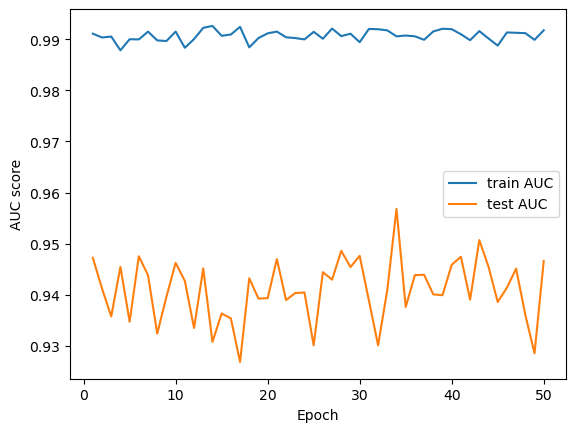

In [23]:
best_auc = 0
best_acc = 0
best_epoch = 0
patience = 5
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)
    
    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_pneumoniamnist.pth')
    #     stop_counter = 0
    # else:
    #     stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    # if stop_counter >= patience:
    #     print("Early stopping triggered")
    #     break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

## Resnet18 without dropout

In [24]:
model.load_state_dict(torch.load("best_pretraind_model_pneumoniamnist.pth"))

<All keys matched successfully>

In [26]:
SEED = 123
BATCH_SIZE = 128
lr = 0.001 # using smaller learning rate is better
epoch_decay = 2e-3
weight_decay = 1e-5
margin = 1.0

In [27]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

100%|██████████| 74/74 [00:03<00:00, 24.28it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.8493593369200343, Train ACC: 39.88190314358539
Test AUC: 0.8196415409032731, Test ACC: 73.7724358974359
==> Best test AUC and ACC score updated: 0.8196, 73.7724


100%|██████████| 74/74 [00:03<00:00, 24.38it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.9796902756495224, Train ACC: 37.983432455395075
Test AUC: 0.9135969727368881, Test ACC: 70.3301282051282
==> Best test AUC and ACC score updated: 0.9136, 70.3301


100%|██████████| 74/74 [00:03<00:00, 23.70it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.9907162515344667, Train ACC: 35.868309260832625
Test AUC: 0.949341492988746, Test ACC: 67.80128205128206
==> Best test AUC and ACC score updated: 0.9493, 67.8013


100%|██████████| 74/74 [00:03<00:00, 23.64it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.9896320174321712, Train ACC: 33.05267629566695
Test AUC: 0.9509977089115909, Test ACC: 66.0448717948718
==> Best test AUC and ACC score updated: 0.9510, 66.0449


100%|██████████| 74/74 [00:03<00:00, 22.82it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.9918286158388535, Train ACC: 32.179269328802036
Test AUC: 0.9501639316216561, Test ACC: 63.24679487179487


100%|██████████| 74/74 [00:03<00:00, 23.46it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.9911063421792047, Train ACC: 32.76975361087511
Test AUC: 0.945980090115625, Test ACC: 63.868589743589745


100%|██████████| 74/74 [00:03<00:00, 21.81it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.9908544427903239, Train ACC: 32.20815632965166
Test AUC: 0.9512422510264799, Test ACC: 62.9775641025641
==> Best test AUC and ACC score updated: 0.9512, 62.9776


100%|██████████| 74/74 [00:03<00:00, 22.32it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.9926458655108672, Train ACC: 31.626168224299064
Test AUC: 0.9391617501580203, Test ACC: 63.14423076923077


100%|██████████| 74/74 [00:03<00:00, 22.88it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.9909587749376706, Train ACC: 32.74171622769754
Test AUC: 0.9457354775402246, Test ACC: 63.81089743589744


100%|██████████| 74/74 [00:03<00:00, 21.39it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.9908093701345917, Train ACC: 32.79354290569244
Test AUC: 0.9566897149946489, Test ACC: 64.14102564102564
==> Best test AUC and ACC score updated: 0.9567, 64.1410


100%|██████████| 74/74 [00:03<00:00, 23.66it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.990756556755516, Train ACC: 31.618946474086663
Test AUC: 0.9413939844509411, Test ACC: 61.67628205128205


100%|██████████| 74/74 [00:03<00:00, 23.72it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.9914929674257398, Train ACC: 32.02803738317757
Test AUC: 0.9512037052035438, Test ACC: 63.10576923076923


100%|██████████| 74/74 [00:03<00:00, 22.75it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.9918993170932164, Train ACC: 31.32285471537808
Test AUC: 0.9473668712617606, Test ACC: 62.15384615384615


100%|██████████| 74/74 [00:03<00:00, 23.58it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.9922773068424267, Train ACC: 32.88317757009346
Test AUC: 0.9593283743608534, Test ACC: 62.81730769230769
==> Best test AUC and ACC score updated: 0.9593, 62.8173


100%|██████████| 74/74 [00:03<00:00, 23.73it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.9903409654374227, Train ACC: 32.47153780798641
Test AUC: 0.9486978704561972, Test ACC: 63.57371794871795


100%|██████████| 74/74 [00:03<00:00, 23.44it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.9910276289399431, Train ACC: 32.120645709430754
Test AUC: 0.9468066966376185, Test ACC: 63.14102564102564


100%|██████████| 74/74 [00:04<00:00, 18.46it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.9910255845301776, Train ACC: 32.734069668649106
Test AUC: 0.950016729001961, Test ACC: 63.21474358974359


100%|██████████| 74/74 [00:04<00:00, 17.53it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.9905904671710198, Train ACC: 31.300764655904842
Test AUC: 0.9531433470651123, Test ACC: 61.881410256410255


100%|██████████| 74/74 [00:03<00:00, 23.49it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.9911776797810448, Train ACC: 31.87128292268479
Test AUC: 0.9613371518824767, Test ACC: 61.80448717948718
==> Best test AUC and ACC score updated: 0.9613, 61.8045


100%|██████████| 74/74 [00:03<00:00, 23.66it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9909720280669397, Train ACC: 32.51104502973662
Test AUC: 0.9508211736335725, Test ACC: 62.91346153846154


100%|██████████| 74/74 [00:03<00:00, 23.01it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9905545326929639, Train ACC: 32.58198810535259
Test AUC: 0.9457627881555976, Test ACC: 62.73397435897436


100%|██████████| 74/74 [00:03<00:00, 23.46it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.9901125757052822, Train ACC: 32.58878504672897
Test AUC: 0.9402978648688791, Test ACC: 63.717948717948715


100%|██████████| 74/74 [00:03<00:00, 23.81it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9910643289563957, Train ACC: 30.84069668649108
Test AUC: 0.9458164953106294, Test ACC: 62.58974358974359


100%|██████████| 74/74 [00:03<00:00, 22.98it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9914395452910125, Train ACC: 32.3338997451147
Test AUC: 0.9508278208060631, Test ACC: 63.48717948717949


100%|██████████| 74/74 [00:03<00:00, 23.63it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.9916453002000818, Train ACC: 31.6142735768904
Test AUC: 0.9510105495387495, Test ACC: 62.583333333333336


100%|██████████| 74/74 [00:03<00:00, 23.67it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.9919395621396739, Train ACC: 31.369583687340697
Test AUC: 0.9428788387455354, Test ACC: 63.46153846153846


100%|██████████| 74/74 [00:03<00:00, 23.68it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9904870059557122, Train ACC: 31.51316907391674
Test AUC: 0.943067564386858, Test ACC: 62.65384615384615


100%|██████████| 74/74 [00:03<00:00, 23.51it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.9906595150954136, Train ACC: 32.03058623619371
Test AUC: 0.9520407693507554, Test ACC: 62.96153846153846


100%|██████████| 74/74 [00:03<00:00, 23.13it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.991511014880565, Train ACC: 31.481308411214954
Test AUC: 0.9409327741931106, Test ACC: 62.02884615384615


100%|██████████| 74/74 [00:03<00:00, 23.50it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9883601547651479, Train ACC: 30.510620220900595
Test AUC: 0.9371092395430468, Test ACC: 61.15384615384615


100%|██████████| 74/74 [00:03<00:00, 23.77it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.9907951936490288, Train ACC: 32.10025488530162
Test AUC: 0.942307624948002, Test ACC: 63.32051282051282


100%|██████████| 74/74 [00:03<00:00, 23.00it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9907993984441229, Train ACC: 31.396346644010194
Test AUC: 0.9463003553679666, Test ACC: 61.583333333333336


100%|██████████| 74/74 [00:03<00:00, 23.72it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9906360994765575, Train ACC: 32.19583687340697
Test AUC: 0.9421712726353169, Test ACC: 63.06410256410256


100%|██████████| 74/74 [00:03<00:00, 23.54it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9903542445696918, Train ACC: 30.58623619371283
Test AUC: 0.9419552600850322, Test ACC: 60.28525641025641


100%|██████████| 74/74 [00:03<00:00, 22.41it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9904218226408398, Train ACC: 31.109175870858113
Test AUC: 0.9400855179897205, Test ACC: 62.18269230769231


100%|██████████| 74/74 [00:03<00:00, 24.00it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.989375362628073, Train ACC: 31.611299915038234
Test AUC: 0.946941203963919, Test ACC: 61.743589743589745


100%|██████████| 74/74 [00:03<00:00, 23.69it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.9904807127924187, Train ACC: 31.323704333050127
Test AUC: 0.9497337283176861, Test ACC: 61.98397435897436


100%|██████████| 74/74 [00:03<00:00, 23.11it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9922028690942757, Train ACC: 32.54035683942226
Test AUC: 0.9510305209215101, Test ACC: 63.57692307692308


100%|██████████| 74/74 [00:03<00:00, 23.79it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9915146098545625, Train ACC: 30.548428207306713
Test AUC: 0.9374368122708671, Test ACC: 60.669871794871796


100%|██████████| 74/74 [00:03<00:00, 22.88it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9907222489602945, Train ACC: 31.793542905692437
Test AUC: 0.9396094638275769, Test ACC: 62.57692307692308


100%|██████████| 74/74 [00:03<00:00, 23.29it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9903736378818501, Train ACC: 32.3322005097706
Test AUC: 0.9416828742196449, Test ACC: 62.60897435897436


100%|██████████| 74/74 [00:03<00:00, 23.71it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9916395945865009, Train ACC: 31.596006796941378
Test AUC: 0.9469314852900993, Test ACC: 62.94551282051282


100%|██████████| 74/74 [00:03<00:00, 23.09it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9890575921293165, Train ACC: 30.665675446049278
Test AUC: 0.9371887735347112, Test ACC: 61.166666666666664


100%|██████████| 74/74 [00:03<00:00, 23.66it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9894076210434879, Train ACC: 31.8857264231096
Test AUC: 0.9432025554591437, Test ACC: 62.80448717948718


100%|██████████| 74/74 [00:03<00:00, 23.65it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9906178092151056, Train ACC: 33.19073916737468
Test AUC: 0.9395066973078633, Test ACC: 64.06410256410257


100%|██████████| 74/74 [00:03<00:00, 22.85it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.9895674673761263, Train ACC: 31.885301614273576
Test AUC: 0.9348237618141055, Test ACC: 61.17628205128205


100%|██████████| 74/74 [00:03<00:00, 23.82it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9901318867199155, Train ACC: 32.141886151231944
Test AUC: 0.9390354647723045, Test ACC: 62.73076923076923


100%|██████████| 74/74 [00:03<00:00, 23.58it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9900763939070785, Train ACC: 31.605777400169924
Test AUC: 0.9417899440552775, Test ACC: 61.52564102564103


100%|██████████| 74/74 [00:03<00:00, 22.65it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9897478354340027, Train ACC: 31.844944774851317
Test AUC: 0.9444390052085734, Test ACC: 62.44230769230769


100%|██████████| 74/74 [00:03<00:00, 23.71it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.987897040319319, Train ACC: 31.361512319456246
Test AUC: 0.9398746407849533, Test ACC: 61.22435897435897
Best test AUC: 0.9613 and ACC: 61.8045 achieved at epoch 19


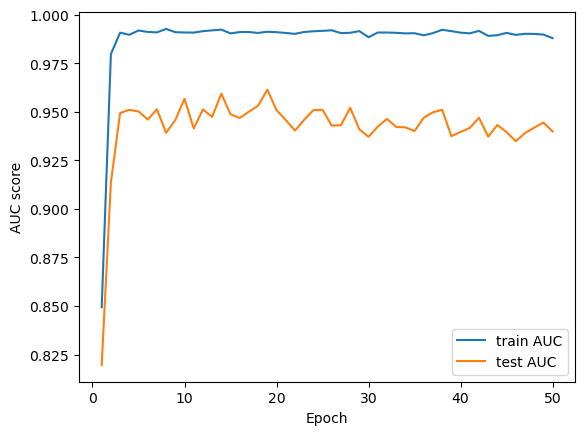

In [28]:
# training and testing
best_auc = 0
best_acc = 0
best_epoch = 0
patience = 5
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)
    
    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_pneumoniamnist_no_dropout.pth')
    #     stop_counter = 0
    # else:
    #     stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    # if stop_counter >= patience:
    #     print("Early stopping triggered")
    #     break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()